# Using BERT to quantify the predictability of writing style

Transformer-based models of language such as BERT have been used create state-of-the-art models for a wide range of NLP tasks over the past few years. 
BERT's next-sentence prediction's capability have recently been used to <a href='https://tedunderwood.com/2020/07/05/how-predictable-is-fiction/'>assess the predictability of fiction.</a> 
This notebook attempts to use another task that BERT can be trained on, masked language modeling, to assess the predictability of style within a single sentence.

In lay language, Masked language modeling can be described as a fill-in-the-blanks task. A model is given a sentence, each token in the sentence is hidden and the model made to predict it using the surrounding context words. The idea is that we can use the probability generated by such a model to assess how predictable the style of a sentence is. For instance, using English as an example, in the following sentence:

    His hair as gold as the sun , his eyes blue like the [MASK].

BERT (English) can predict `sky` with a 27.1% probability. But in the this sentence:

    `The [MASK] above the port was the color of television, tuned to a dead channel`

the probability of `sky` falls much lower, with BERT instead giving tokens such as `screen`, `window` or `panel` the highest probabilities. In short, BERT can predict trite comparisons much better than creative ones. 

<br>
<br>

I would like to extend this beyond the simple scope of comparison, from a single word to the scale of a complete sentence, in order to evaluate that sentence's predictability. This is possible because BERT's probability would assess a couple of things typically associated with literary creativity: 
- the "preciosity" of a word (given two synonyms, the rarer one will receive a lower probability)
- the unexpectedness of comparison and language (we might say that BERT's probabilities are computed following paradigmatic (predicting a word over others) and syntagmatic (based on its context) axes, whose order are subverted by literary language)

The predictability score could then be used as a proxy value for literary creativity. Being able to quantify such a value would be interesting for literary history and comparative literature because it would create a metric of creativity to compare against signs of literary recognition, enabling us to evaluate how much a certain literary culture values conformity over creativity (and vice-versa).

<br>
<br>

The insight that a language model can be used to assert how "common" the style of sentence is not entirely new. The scoring of sentences by language models, knowng as <a href='https://en.wikipedia.org/wiki/Perplexity#:~:text=of%20size%20N).-,Perplexity%20per%20word,over%20entire%20sentences%20or%20texts.'>perplexity</a> has been used in task such as automatic translation to rate which of the outputs of a model might be the most well-formed sentence in particular target language. The main differences with our case are that:
1. Traditional language models are sequential, working from left to right, rather than the with the whole sentence as a context.
2. Working with literary texts, we can assume that the sentences we will feed into the model will be generally gramatically correct.

Regarding point 1, BERT gives us an advantage over sequential language models. Because it is bi-directional, it allows us to consider the context on both sides of a word, which is closer to how a human reader would assert the unexpectedness of a single word. One <a href=' https://arxiv.org/pdf/1906.00363.pdf'>paper</a> thus averaged the probabilities of the tokens in a sentence ($\prod_{i=1}^{n}p(w_{i}|w_{1},...,w_{i-1},w_{i+1},...,w_{n}))^{-1/n} $) to predict whether a sentence is non-sensical or not - similar to how the perplexity score is used by traditional language models.

Point 2 is tied to language specific issues, adressed below.

### Language specifics

Working with Korean and with literary texts, the above formula does present some limitations. For instance, Korean can mark the object of a verb with a specific particle (를/을). Predicting this particle being present between a noun and a verb is not hard (tokenizers such as BERT's separate it from the noun to which it would be attached). Therefore the token would be assigned a high probability. However, case particles can and are often omitted depending on context and individual preferences. Including it in the scoring of a sentence might therefore introduce bias, ranking writers who use it extensively as less creative than writers who use it more sparingly. On the other hand, as noted in Point 2 above, we are not interested in evaluating the grammatical correctness of a sentence, and therefore including case particles bring little additional information to our metric. The same is true of punctuation, pronouns, prepositions... We therefore opt to restrict the model to predicting masked nouns, adjectives and verbs (all tokens are still nonetheless used as context).

### Technical specifics

This approach requires us to be able to control the tokenization process because we want to be able to select the words which we will mask for prediction. This is more complex than it seems, because most implementations of BERT uses a type of tokenizer that works splitting more complex words into smaller words to retain a small vocabulary size. This choice of tokenizing method is a powerful way to deal with out-of-vocabulary words (they will be split into smaller, in-vocabulary pieces). 

To address this issue, I've pre-tokenized the training data used during fine-tuning. I then train a new tokenizer with a large dictionary size and use its vocabulary to update the tokenizer's vocabulary of the base BERT model used for fine-tuning. (see <a href='https://github.com/digitalprk/sih_notebooks/blob/master/run_language_modeling.py'>here</a>).

The base model used was <a href='https://github.com/SKTBrain/KoBERT'>KoBERT</a>, a BERT model trained by the SK Telecom team on South Korean language data. The model was fine-tuned on a small (1.6Gb) corpus of North Korean language data comprising novels, literary journals, newspapers, non-fiction books and the complete works of Kim Il-Sung and Kim Jong-Il.

### Data

Sentences were extracted from four types of sources:
1. The Korean Central News Agency (the North Korean state's press agency)
2. Novels by prestigious writers (recognized for their literary excellence with a state sanctioned distinction)
3. Novels by "regular" writers
4. Canonical novels (fictional accounts of the lives of Kim Il-Sung and Kim Jong-Il held to be of the highest literary quality). 

None of the novels or press releases used were present in the corpus used to fine-tune the model. However, the corpus did contain similar content (literary sources and press releases for different years).

### Results

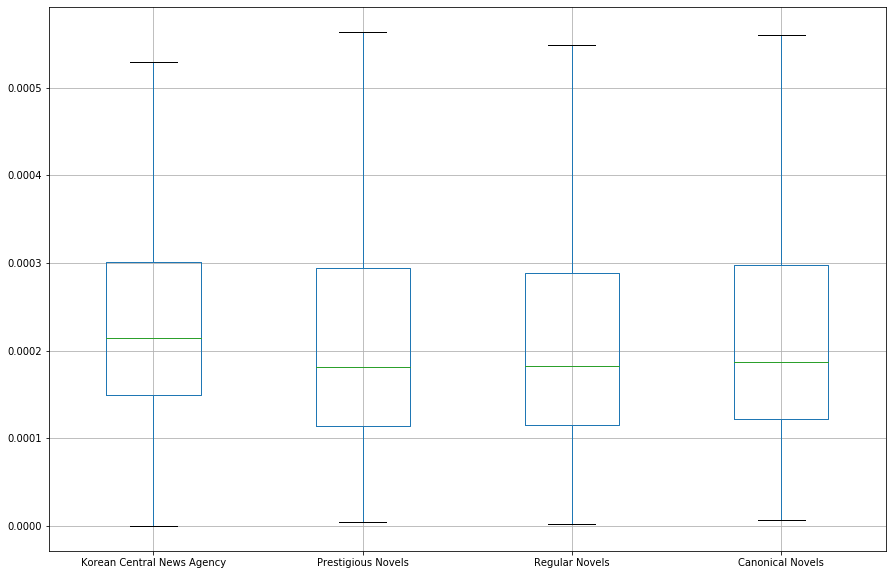

In [44]:
%matplotlib inline
df.boxplot(figsize = (15, 10), showfliers=False)

In [41]:
from scipy import stats
from itertools import combinations
for a, b in list(combinations(df.columns, 2)):
    print(f'{a} : {b}')
    print(stats.ttest_ind(df[a],df[b]))

Korean Central News Agency : Prestigious Novels
Ttest_indResult(statistic=-1.9925895746961764, pvalue=0.04633354914603183)
Korean Central News Agency : Regular Novels
Ttest_indResult(statistic=-0.19871218920210995, pvalue=0.8424919290229935)
Korean Central News Agency : Canonical Novels
Ttest_indResult(statistic=-2.285899975225016, pvalue=0.022280935649715887)
Prestigious Novels : Regular Novels
Ttest_indResult(statistic=1.6062157018139056, pvalue=0.10825810476960021)
Prestigious Novels : Canonical Novels
Ttest_indResult(statistic=0.02962811881368405, pvalue=0.9763642309487608)
Regular Novels : Canonical Novels
Ttest_indResult(statistic=-1.7660209785665917, pvalue=0.07742284297112875)


In [45]:
### Intepretation

In [1]:
from transformers import AutoModelWithLMHead, AutoTokenizer
import torch
import logging
import numpy as np
import pickle

logging.getLogger("transformers.tokenization_utils").setLevel(logging.ERROR)

tokenizer = AutoTokenizer.from_pretrained("./jobert")
model = AutoModelWithLMHead.from_pretrained("./jobert")

I0921 21:17:51.718943 49680 file_utils.py:39] PyTorch version 1.6.0 available.
I0921 21:17:56.186017 49680 file_utils.py:55] TensorFlow version 2.2.0 available.
I0921 21:17:57.334977 49680 configuration_utils.py:262] loading configuration file ./jobert\config.json
I0921 21:17:57.335977 49680 configuration_utils.py:300] Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "type_vocab_size": 2,
  "vocab_size": 20839
}

I0921 21:17:57.336944 49680 tokenization_utils_base.py:1167] Model name './jobert' not found in model shortcut name list (bert-base-uncased, bert-large-uncased, bert-base-cased, bert-lar

In [3]:
from konlpy.tag import Komoran
komoran = Komoran()

In [2]:
def compute_word_proba(sequence, word):
    global model, tokenizer
    input_ids = tokenizer.encode(sequence, return_tensors="pt")
    mask_token_index = torch.where(input_ids == tokenizer.mask_token_id)[1]
    token_logits = model(input_ids)[0]
    mask_token_logits = token_logits[0, mask_token_index, :]
    mask_token_logits = torch.softmax(mask_token_logits, dim=1)
    sought_after_token = word
    sought_after_token_id = tokenizer.encode(sought_after_token, add_special_tokens=False, add_prefix_space=True)[0]
    token_score = mask_token_logits[:, sought_after_token_id]
    return token_score.detach().numpy()[0]

def compute_word_by_word_proba(sequence):
    global tokenizer
    global komoran
    pos_filter = ['VV', 'VA', 'NNG', 'NNP', 'MAG', 'NA', 'SN', 'XR'] # we only want to predict verbs, nouns and adjectives
    word_dict = {}
    tokenized_sequence = komoran.pos(sequence)
    sequence = ' '.join([token for token, pos in tokenized_sequence])
    for token, pos in tokenized_sequence:
        #print(token, pos)
        if pos in pos_filter:
            masked_sequence = sequence.replace(token, tokenizer.mask_token)
            word_dict[token] = compute_word_proba(masked_sequence, token)
    return word_dict

def geometric_mean(series):
    return np.array(series, dtype=np.float64).prod()**(1.0/len(series))

def compute_sentence_score(sentence):
    return geometric_mean(list(compute_word_by_word_proba(sentence).values()))

In [27]:
import os

sample_data_path = './samples'
sample_files = [file for file in os.listdir(sample_data_path) if not file.endswith('-tokenized.txt')]
final_results = {}
for file in sample_files:
    with open(os.path.join(sample_data_path, file), 'r', encoding='utf8') as fp:
        sentences = fp.read().splitlines()
    scores = []
    print(file)
    for i, sentence in enumerate(sentences[:5000]):
        if (i % 50) == 0:
            print(i)
        try:
            score = compute_sentence_score(sentence.replace('\xa0 ', ''))
            scores.append(score)
        except:
            scores.append(np.mean(scores))
            print("Error:", sentence)
            pass
    
    final_results[file] = scores
    
with open('/project/RDS-FASS-NKBert-RW/samples/final_scores.pkl', 'wb') as fp:
    pickle.dump(final_results, fp)


kcna.txt
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500
3550
3600
3650
3700
3750
3800
3850
3900
3950
4000
4050
4100
4150
4200
4250
4300
4350
4400
4450
4500
4550
4600
4650
4700
4750
4800
4850
4900
4950
novels-415.txt
0
50
100
150
200
250
300
350
400
450
500
Error: ≪그가 무엇 때문에 여기에 왔지?
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500
3550
3600
3650
3700
3750
3800
3850
3900
3950
4000
4050
4100
4150
4200
4250
4300
4350
4400
4450
4500
4550
4600
4650
4700
4750
4800
4850
4900
4

FileNotFoundError: [Errno 2] No such file or directory: '/project/RDS-FASS-NKBert-RW/samples/final_scores.pkl'

In [11]:
compute_sentence_score('각도 건설 자 들 과 인민군 군인 들 은 지금 400 리 의 물길 파기 와 굴 뚫 기 구조물 공사 갑문 건설 을 힘 있 게 내밀 고 있 다')

0.0006593437362473346

In [28]:
import pandas as pd
df = pd.DataFrame(final_results)
df

,kcna.txt,novels-415.txt,novels.txt,pulmyol.txt
0,0.000181,0.000030,0.000079,0.000137
1,0.000135,0.000111,0.000200,0.000369
2,0.000354,0.000450,0.000109,0.000126
3,0.000335,0.000226,0.000079,0.000076
4,0.000132,0.000308,0.000136,0.000206
...,...,...,...,...
4995,0.000366,0.000141,0.000180,0.000254
4996,0.000657,0.000132,0.000041,0.000344
4997,0.000126,0.000085,0.000089,0.000141
4998,0.000209,0.000220,0.000156,0.000166


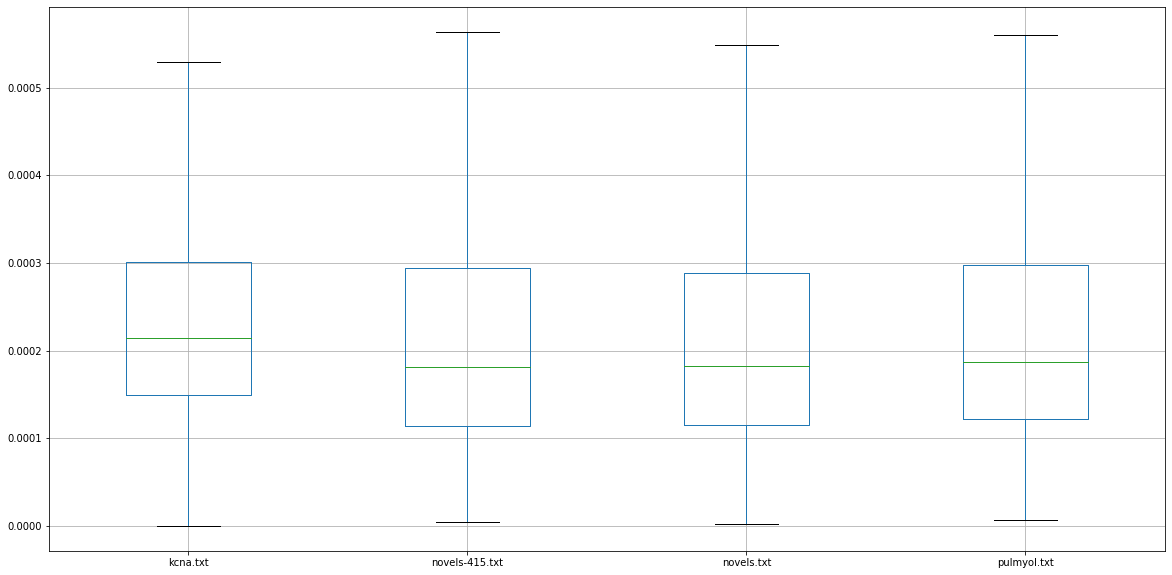

In [29]:
%matplotlib inline
df.boxplot(figsize = (20, 10), showfliers=False)

In [32]:
from scipy import stats
stats.ttest_ind(df['novels.txt'], df['novels-415.txt'])

Ttest_indResult(statistic=-1.6062157018139056, pvalue=0.10825810476960021)

In [37]:
from scipy import stats
from itertools import combinations
for a, b in list(combinations(df.columns, 2)):
    print(f'{a} : {b}')
    print(stats.ttest_ind(df[a],df[b]))

kcna.txt : novels-415.txt
Ttest_indResult(statistic=-1.9925895746961764, pvalue=0.04633354914603183)
kcna.txt : novels.txt
Ttest_indResult(statistic=-0.19871218920210995, pvalue=0.8424919290229935)
kcna.txt : pulmyol.txt
Ttest_indResult(statistic=-2.285899975225016, pvalue=0.022280935649715887)
novels-415.txt : novels.txt
Ttest_indResult(statistic=1.6062157018139056, pvalue=0.10825810476960021)
novels-415.txt : pulmyol.txt
Ttest_indResult(statistic=0.02962811881368405, pvalue=0.9763642309487608)
novels.txt : pulmyol.txt
Ttest_indResult(statistic=-1.7660209785665917, pvalue=0.07742284297112875)
